In [1]:
# Imports
import pandas as pd
import numpy as np
from pydub import AudioSegment
import noisereduce as nr
import soundfile as sf

import matplotlib.pyplot as plt

c:\Users\nmcph\anaconda3\envs\heimdall\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


## Audio loading and preprocessing

In [3]:
from preprocess_data import preprocess_data

features, (labels, labels_ohe), transformers = preprocess_data()

c:\Users\nmcph\anaconda3\envs\heimdall\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


## K-Means Clustering and t-SNE for data visualization

In [8]:
# Perform k-means clustering on the keystrokes
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Set k to the number of unique labels logged
cluster_k = len(labels.unique())
kmeans = KMeans(n_clusters=cluster_k, random_state=0, n_init="auto").fit(features)

# Get cluster predictions for each row
predicted_clusters = []
for _, keystroke in features.iterrows():
    predicted_clusters.append(kmeans.predict(keystroke.array.reshape(1, -1)))

predicted_clusters = np.array(predicted_clusters).squeeze()

print(f"{cluster_k} clusters")
print(f"Silhouette score: {silhouette_score(features, kmeans.labels_) :.2f}")

32 clusters
Silhouette score: 0.25


c:\Users\nmcph\anaconda3\envs\heimdall\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


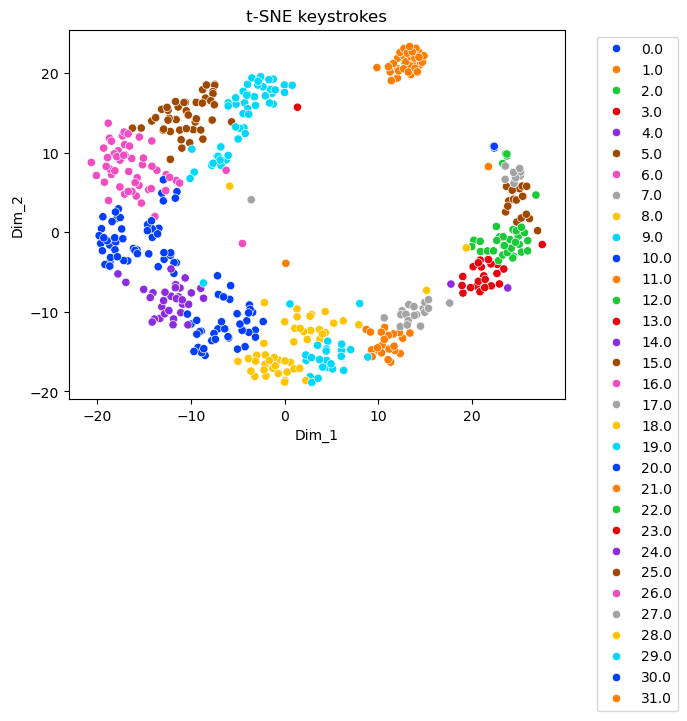

In [9]:
# Plot the data with t-SNE dimensionality reduction to determine if the keystrokes make clusters

from sklearn.manifold import TSNE
import seaborn as sn

def tsne_plot(data, labels=None):
    model = TSNE(n_components = 2, random_state = 0)
    # configuring the parameters
    # the number of components = 2
    # default perplexity = 30
    # default learning rate = 200
    # default Maximum number of iterations
    # for the optimization = 1000
    
    tsne_data = model.fit_transform(data)
    
    # Colors points based on their label, if they have any
    if labels is not None:
        tsne_data = np.vstack((tsne_data.T, labels)).T
        tsne_df = pd.DataFrame(data = tsne_data,
           columns =("Dim_1", "Dim_2", "label"))
    
        # Plotting the result of tsne
        sn.scatterplot(data=tsne_df, x='Dim_1', y='Dim_2',
                       hue='label', palette="bright")
    else:
        tsne_df = pd.DataFrame(data = tsne_data,
           columns =("Dim_1", "Dim_2"))
    
        # Plotting the result of tsne
        sn.scatterplot(data=tsne_df, x='Dim_1', y='Dim_2', palette="bright")
    
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

    plt.title("t-SNE keystrokes")
    plt.show()

tsne_plot(features, predicted_clusters)

## Deep Learning
**TODO:** The data is unbalanced, so that needs to be handled

In [10]:
# Count number of each class
unique_elements, counts = np.unique(np.array(labels), return_counts=True)
count_of_elements = list(zip(unique_elements, counts))
count_of_elements = sorted(count_of_elements, key=lambda x: x[1], reverse=True)

total_elements = counts.sum()

print("Element: frequency of element")
for element, count in count_of_elements:
    print(f"{element}:\t{count / total_elements * 100 :.2f}%")

Element: frequency of element
space:	17.23%
e:	9.62%
h:	7.01%
t:	6.81%
a:	6.01%
s:	5.61%
i:	5.21%
backspace:	5.01%
d:	4.61%
n:	4.61%
o:	4.01%
r:	3.01%
u:	2.40%
w:	2.40%
l:	2.00%
,:	1.60%
m:	1.40%
c:	1.20%
g:	1.20%
shift:	1.20%
y:	1.20%
p:	1.00%
f:	0.80%
k:	0.80%
shift_r:	0.80%
b:	0.60%
q:	0.60%
v:	0.60%
!:	0.40%
"":	0.40%
-:	0.40%
j:	0.20%


In [36]:
# Separate data into training and test sets
from sklearn.model_selection import train_test_split

X = features
y = labels_ohe

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [37]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [26]:
import torch
import torch.nn as nn

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [38]:
# Convert data to tensors
X_train = torch.tensor(X_train.to_numpy().astype(np.float32)).to(device)
y_train = torch.tensor(y_train.astype(np.float32)).to(device)
X_test = torch.from_numpy(X_test.to_numpy().astype(np.float32)).to(device)
y_test = torch.from_numpy(y_test.astype(np.float32)).to(device)

In [39]:
input_size = X_train.shape[1]
output_size = y_train.shape[1]
hidden_size = [128, 64, 64] # Hidden layer sizes
print(f'Input size: {input_size}\nOutput size: {output_size}')

Input size: 20
Output size: 32


In [40]:
# Define model
class Model(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.linear_sequential_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size[0]),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size[0], hidden_size[1]),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size[1], hidden_size[2]),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size[2], output_size),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        logits = self.linear_sequential_stack(x)
        return logits

model = Model(input_size, hidden_size, output_size).to(device)
l = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, momentum=0.9)

In [41]:
# Get the F1 score
from sklearn.metrics import f1_score
import numpy as np
def getF1(pred_y: torch.Tensor, true_y: torch.Tensor):
    pred_y = pred_y.cpu().detach().numpy()
    pred_y = np.argmax(pred_y, axis=1)
    
    true_y = true_y.cpu().detach().numpy()
    true_y = np.argmax(true_y, axis=1)

    return f1_score(true_y, pred_y, average='macro')

In [42]:
torch.manual_seed(1112)
np.random.seed(1112)

num_epochs = 1000

train_loss = [None]*num_epochs
val_loss = [None]*num_epochs

train_f1 = [None]*num_epochs
val_f1 = [None]*num_epochs

for epoch in range(num_epochs):
    model.train()

    pred = model(X_train)
    loss = l(pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    tr_loss = loss.item()
    tr_f1 = getF1(pred, y_train)

    model.eval()
    
    pred = model(X_test)
    te_loss = l(pred, y_test).item()
    te_f1 = getF1(pred, y_test)


    train_loss[epoch] = tr_loss
    val_loss[epoch] = te_loss
    train_f1[epoch] = tr_f1
    val_f1[epoch] = te_f1
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f'Epoch {epoch+1} - train loss: {tr_loss :.4f} - val loss: {te_loss :.4f} - val F1-Score: {te_f1:.4f}')

Epoch 1 - train loss: 3.4657 - val loss: 3.4500 - val F1-Score: 0.0177
Epoch 10 - train loss: 3.3757 - val loss: 3.4279 - val F1-Score: 0.0140
Epoch 20 - train loss: 3.3802 - val loss: 3.4380 - val F1-Score: 0.0121
Epoch 30 - train loss: 3.3802 - val loss: 3.4280 - val F1-Score: 0.0165
Epoch 40 - train loss: 3.3777 - val loss: 3.4380 - val F1-Score: 0.0067
Epoch 50 - train loss: 3.3802 - val loss: 3.4380 - val F1-Score: 0.0066
Epoch 60 - train loss: 3.3852 - val loss: 3.4380 - val F1-Score: 0.0066
Epoch 70 - train loss: 3.3852 - val loss: 3.4380 - val F1-Score: 0.0066
Epoch 80 - train loss: 3.3777 - val loss: 3.4380 - val F1-Score: 0.0067
Epoch 90 - train loss: 3.3777 - val loss: 3.4380 - val F1-Score: 0.0140
Epoch 100 - train loss: 3.3676 - val loss: 3.4280 - val F1-Score: 0.0139
Epoch 110 - train loss: 3.3802 - val loss: 3.4380 - val F1-Score: 0.0124
Epoch 120 - train loss: 3.3702 - val loss: 3.4280 - val F1-Score: 0.0139
Epoch 130 - train loss: 3.3677 - val loss: 3.4280 - val F1-Sco

In [43]:
pt_trainhist = pd.DataFrame({'train_loss': train_loss, 'train_f1': train_f1, 'val_loss': val_loss, 'val_f1': val_f1, 'epoch': np.arange(num_epochs)})
pt_trainhist.tail()

,train_loss,train_f1,val_loss,val_f1,epoch
995,3.365158,0.017260,3.42804,0.013312,995
996,3.365158,0.017220,3.42804,0.013312,996
997,3.367664,0.016698,3.42804,0.013312,997
998,3.365158,0.017106,3.42804,0.013312,998
999,3.367664,0.016803,3.42804,0.013312,999


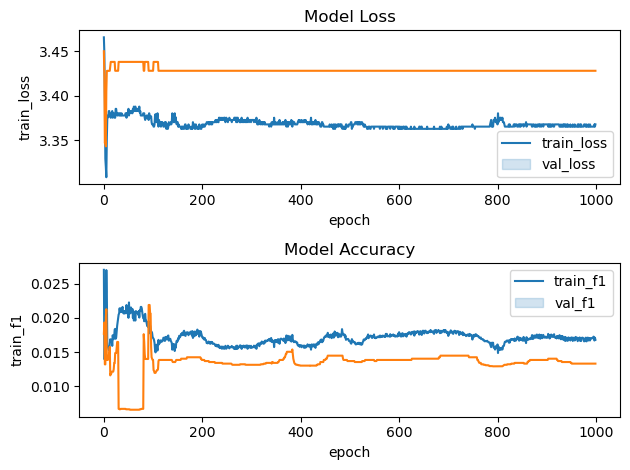

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.subplot(2, 1, 1)
plt.title("Model Loss")
sns.lineplot(x='epoch', y='train_loss', data=pt_trainhist)
sns.lineplot(x='epoch', y='val_loss', data=pt_trainhist)
plt.legend(labels=['train_loss', 'val_loss'])

plt.subplot(2, 1, 2)
plt.title("Model Accuracy")
sns.lineplot(x='epoch', y='train_f1', data=pt_trainhist)
sns.lineplot(x='epoch', y='val_f1', data=pt_trainhist)
plt.legend(labels=['train_f1', 'val_f1'])

plt.tight_layout()
plt.show()

In [47]:
predictions = model(torch.tensor(X[:50].to_numpy().astype(np.float32)).to(device)).detach().numpy()
decoded_predictions = transformers['encoder'].inverse_transform(predictions)
print(decoded_predictions)

[['backspace']
 ['e']
 ['backspace']
 ['e']
 ['backspace']
 ['e']
 ['e']
 ['e']
 ['e']
 ['backspace']
 ['e']
 ['e']
 ['e']
 ['e']
 ['backspace']
 ['e']
 ['e']
 ['e']
 ['backspace']
 ['backspace']
 ['e']
 ['e']
 ['e']
 ['backspace']
 ['e']
 ['e']
 ['e']
 ['e']
 ['e']
 ['backspace']
 ['e']
 ['e']
 ['e']
 ['backspace']
 ['e']
 ['backspace']
 ['e']
 ['e']
 ['e']
 ['e']
 ['backspace']
 ['e']
 ['backspace']
 ['backspace']
 ['backspace']
 ['backspace']
 ['e']
 ['e']
 ['e']
 ['e']]
